In [ ]:
"""
Combined Enhanced Triples Retrieval Pipeline with LangGraph and Excel I/O

Precomputations (done once):
  - Load and parse a triples file (each line is a triple).
  - Build indexes (entity, subject, object-to–subject, and triple text mapping).
  - Precompute tf-idf and dense retrieval models for the full corpus.

Pipeline (as a LangGraph state machine):
  1. Load configuration and initialize Azure OpenAI client.
  2. Load and parse the triples file.
  3. Build indexes and mappings.
  4. Precompute retrieval models.
  5. For each query:
       a. Parse the query using LLM.
       b. Retrieve relevant triples using enhanced retrieval (with primary id expansion).
       c. Generate a final answer using the retrieved candidate set.
  6. Process queries from an Excel file: for each query, also store the retrieved
     triples for multiple values of k (e.g. k = 1,2,3,5,8,13,15,21) in separate columns.
"""

import json
import os
import re
import time
from types import SimpleNamespace
from collections import defaultdict

import torch
import pandas as pd

from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
from openai import AzureOpenAI

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from transformers import (
    DPRQuestionEncoder, DPRQuestionEncoderTokenizer,
    DPRContextEncoder, DPRContextEncoderTokenizer
)

# Prevent duplicate library load issues
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# ----------------- LangGraph Imports ----------------- #
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import TypedDict, List, Dict
from typing_extensions import Annotated

# ----------------- State Definition ----------------- #
class MyState(TypedDict):
    messages: Annotated[List[dict], add_messages]    # List of messages (each a dict with keys "role", "content")
    triple_file_path: str                             # Path to the triple file
    triple_text: str                                  # Raw text from the triple file
    triple_documents: List[dict]                      # List of triple documents (each a dict with keys: subject, predicate, object, text)
    entity_index: Dict[str, List[str]]                # Map from token (subject/object) to triple texts
    subject_index: Dict[str, List[str]]               # Map from subject to triple texts
    object_to_subject: Dict[str, List[str]]           # Map from object to subjects
    corpus: List[str]                                 # List of triple texts (corpus)
    text_to_doc: Dict[str, dict]                      # Mapping: triple text -> triple document
    text_to_index: Dict[str, int]                     # Mapping: triple text -> index in corpus
    parsed_query: Dict                                # Parsed query from the LLM (includes entities, relationships, goal)
    ranked_triples: List[tuple]                       # List of (triple_text, score) after retrieval
    final_answer: str                                 # Final answer generated by the LLM

# Global store for the state
GLOBAL_STATE = {}



c:\Users\z0050t3j\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ----------------- Configuration & Azure Client Setup ----------------- #
def load_config():
    config_path = r"config.json" 
    try:
        with open(config_path, "r", encoding="utf-8") as f:
            return json.load(f, object_hook=lambda d: SimpleNamespace(**d))
    except FileNotFoundError:
        raise FileNotFoundError("Config file not found. Please check the path.")

def initialize_azure_client(config):
    client = SecretClient(vault_url=config.key_vault_url, credential=DefaultAzureCredential())
    secret = client.get_secret(config.dev_secret_name)
    return AzureOpenAI(api_key=secret.value,
                       api_version=config.chat.api_version,
                       azure_endpoint=config.chat.azure_endpoint)

In [4]:
# ----------------- Node 1: Read Triple File ----------------- #
def read_triple_text_node(state: MyState):
    file_path = state["triple_file_path"]
    with open(file_path, "r", encoding="utf-8") as f:
        triple_text = f.read()
    return {"triple_text": triple_text}

# ----------------- Node 2: Prepare Triple Documents ----------------- #
def prepare_triple_documents_node(state: MyState):
    triple_text = state["triple_text"]
    triple_docs = []
    for line in triple_text.splitlines():
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) < 3:
            continue
        triple_docs.append({
            "subject": parts[0],
            "predicate": parts[1],
            "object": " ".join(parts[2:]),
            "text": line
        })
    return {"triple_documents": triple_docs}

In [5]:
# ----------------- Node 3: Build Indexes ----------------- #
def build_indexes_node(state: MyState):
    triple_docs = state["triple_documents"]
    # Build entity_index: subject and object tokens map to triple texts.
    entity_index = defaultdict(list)
    for triple in triple_docs:
        entity_index[triple["subject"]].append(triple["text"])
        entity_index[triple["object"]].append(triple["text"])
    # Build subject_index: subject -> triple texts.
    subject_index = defaultdict(list)
    for triple in triple_docs:
        subject_index[triple["subject"]].append(triple["text"])
    # Build object_to_subject: object -> list of subjects.
    obj_to_subj = defaultdict(set)
    for triple in triple_docs:
        obj_to_subj[triple["object"]].add(triple["subject"])
    object_to_subject = {k: list(v) for k, v in obj_to_subj.items()}
    # Build corpus and mappings.
    corpus = []
    text_to_doc = {}
    text_to_index = {}
    for idx, triple in enumerate(triple_docs):
        ttext = triple["text"]
        corpus.append(ttext)
        text_to_doc[ttext] = triple
        text_to_index[ttext] = idx
    # Store in GLOBAL_STATE
    GLOBAL_STATE["entity_index"] = dict(entity_index)
    GLOBAL_STATE["subject_index"] = dict(subject_index)
    GLOBAL_STATE["object_to_subject"] = object_to_subject
    GLOBAL_STATE["corpus"] = corpus
    GLOBAL_STATE["text_to_doc"] = text_to_doc
    GLOBAL_STATE["text_to_index"] = text_to_index
    return {
        "entity_index": dict(entity_index),
        "subject_index": dict(subject_index),
        "object_to_subject": object_to_subject,
        "corpus": corpus,
        "text_to_doc": text_to_doc,
        "text_to_index": text_to_index
    }

In [6]:
# ----------------- Node 4: Precompute Retrieval Models ----------------- #
def precompute_models_node(state: MyState):
    corpus = GLOBAL_STATE["corpus"]
    # TF-IDF vectorizer using a simple tokenizer.
    def tokenize_text(text: str):
        return re.findall(r'\w+', text.lower())
    tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_text, stop_words='english')
    tfidf_vectorizer.fit(corpus)
    # DPR Context Encoder setup.
    dpr_context_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
    dpr_context_model = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
    # Precompute DPR dense embeddings for each document in corpus.
    def precompute_dense_embeddings(corpus, batch_size=16):
        embeddings = []
        for i in range(0, len(corpus), batch_size):
            batch = corpus[i:i+batch_size]
            inputs = dpr_context_tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = dpr_context_model(**inputs)
            embeddings.append(outputs.pooler_output)
        return torch.cat(embeddings, dim=0)
    dense_embeddings = precompute_dense_embeddings(corpus, batch_size=16)
    GLOBAL_STATE["tfidf_vectorizer"] = tfidf_vectorizer
    GLOBAL_STATE["dense_embeddings"] = dense_embeddings
    # Also load DPR Question Encoder for ranking.
    dpr_question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
    dpr_question_model = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
    GLOBAL_STATE["dpr_question_tokenizer"] = dpr_question_tokenizer
    GLOBAL_STATE["dpr_question_model"] = dpr_question_model
    return {
        "corpus": corpus,
    }


In [7]:
def parse_query_node(state: MyState):
    query = state["messages"][-1].content
    config = load_config()
    llm = initialize_azure_client(config)
    prompt = [
        {
                        "role": "system",
            "content": f"""
            You are given a natural language query related to employee and organization data. Extract the following details from the query:
            - Entities mentioned in the query (e.g., Person name, Organization ID )
            - Relationships or attributes being asked for (e.g., line manager, contact info, worksFor)
            - Map these relationships or attributes to the correct schema predicates as defined below:
            - Person type: Person
            - Organization type: Organization
            - Application type: Application
            - Process Type: Process
            - Works For: worksFor
            - Email address: email
            - last Name: familyName
            - First Name: givenName
            - Organisation name : name
            - Employee status: status
            - Description of the organisation : description
            - Location: location
            - Identifier (GID): gid
            - Job Title: jobTitle
            - Functional Manager: functionalManager
            - Manager: hasManager
            - Manges/reporting to: manages
            - Contact Info: telephone
            - User Type: userType
            - Parent Organization: parentOrganization
            - Has Head: hasHead
            - Has Child Organization: hasChildOrganization
            - Organisation has Process: hasProcess
            - Title of the application: appName
            - Description of the application : appDescription
            - Application access link : accessLink 
            - Application link : appLink
            - Application image: appImage
            - Application belong to the organisation : partOfOrg
            - Application managed by: managedBy
            - people managing application : manages
            - Application Owner: hasOwner
            - Application part of Process: partOfProcess
            - Process title: title
            - Process description: description
            - Process description: description
            - Process has application: hasApplication
            - Process has owner: hasOwner
            - Process has manager: managedBy
            - Process has child process: hasChildProcess
            - Employee manages process: manages
            - Process has a parent process: prentProcess
            - Process part of an organisation: partOfOrg
            - Process Id : processId
            - Process reference Urls: referenceUrls
            - Process template urls: templateUrls
            - The goal of the query

            Provide the response in a JSON format with keys: "entities", "relationships", "goal".
            Do not include additional formatting other than JSON.
            Sample Output:
            {{
            "entities": {{
                "Dominik Schlueter": "Person",
                "Anubhuti Singh": "Person"
            }},
            "relationships": {{
                "telephone": "phone number",
                "gid": "gid",
                "email": "email"
            }},
            "goal": "To retrieve the phone number, GID, and email address of Dominik Schlueter and Anubhuti Singh."
            }}
            Query: "{query}"
            """
        }
    ]
    response = llm.chat.completions.create(model=config.chat.model, messages=prompt)
    response_content = response.choices[0].message.content.strip()
    parsed_data = json.loads(response_content)

    # Convert them to a consistent format
    entities = parsed_data.get('entities', [])
    relationships = parsed_data.get('relationships', [])
    goal = parsed_data.get('goal', "")

    # Standardize
    if isinstance(entities, dict):
        entity_list = [{"name": k, "type": v} for k, v in entities.items()]
    elif isinstance(entities, list):
        entity_list = entities  
    else:
        entity_list = [entities]
    if isinstance(relationships, dict):
        relationship_list = [{"relation": k, "value": v} for k, v in relationships.items()]
    elif isinstance(relationships, list):
        relationship_list = relationships  
    else:
        relationship_list = [relationships]

    return {
        "parsed_query": {
            "entities": entity_list,
            "relationships": relationship_list,
            "goal": goal
        }
    }


In [8]:
# ----------------- Helper Functions for Ranking ----------------- #
def tfidf_rank_documents(query: str, candidate_texts, vectorizer):
    query_vec = vectorizer.transform([query])
    candidate_vecs = vectorizer.transform(candidate_texts)
    sims = cosine_similarity(query_vec, candidate_vecs)[0]
    ranked = sorted(zip(candidate_texts, sims), key=lambda x: x[1], reverse=True)
    return ranked

def dpr_rank_documents(query: str, candidate_texts, dpr_q_tokenizer, dpr_q_model, dense_embeddings, text_to_index):
    inputs = dpr_q_tokenizer(query, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        query_emb = dpr_q_model(**inputs).pooler_output
    results = []
    for text in candidate_texts:
        idx = text_to_index[text]
        doc_emb = dense_embeddings[idx].unsqueeze(0)
        score = float(torch.nn.functional.cosine_similarity(query_emb, doc_emb, dim=1).item())
        results.append((text, score))
    results.sort(key=lambda x: x[1], reverse=True)
    return results

def rrf_fusion(results1, results2, k=60):
    scores = defaultdict(float)
    for rank, (doc, _) in enumerate(results1, start=1):
        scores[doc] += 1.0 / (k + rank)
    for rank, (doc, _) in enumerate(results2, start=1):
        scores[doc] += 1.0 / (k + rank)
    fused = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return fused

def rank_documents_rrf(query_terms, candidate_texts, vectorizer, dense_embeddings, text_to_index, dpr_q_tokenizer, dpr_q_model):
    query_str = " ".join(query_terms)
    tfidf_results = tfidf_rank_documents(query_str, candidate_texts, vectorizer)
    dense_results = dpr_rank_documents(query_str, candidate_texts, dpr_q_tokenizer, dpr_q_model, dense_embeddings, text_to_index)
    return rrf_fusion(tfidf_results, dense_results, k=60)

In [ ]:
# ----------------- Node 6: Retrieve Relevant Triples ----------------- #
def retrieve_triples_node(state: MyState):
    parsed_query = state["parsed_query"]
    triple_docs = state["triple_documents"]  
    subject_index = GLOBAL_STATE["subject_index"]
    object_to_subject = GLOBAL_STATE["object_to_subject"]
    text_to_doc = GLOBAL_STATE["text_to_doc"]
    text_to_index = GLOBAL_STATE["text_to_index"]
    tfidf_vectorizer = GLOBAL_STATE["tfidf_vectorizer"]
    dense_embeddings = GLOBAL_STATE["dense_embeddings"]
    dpr_q_tokenizer = GLOBAL_STATE["dpr_question_tokenizer"]
    dpr_q_model = GLOBAL_STATE["dpr_question_model"]

    # 1. Extract entities and relationships
    entities = parsed_query.get("entities", [])
    relationships = parsed_query.get("relationships", [])
    query_entities = []
    for ent in entities:
        if isinstance(ent, dict):
            query_entities.append(ent.get("name", ""))
        else:
            query_entities.append(ent)
    query_relationships = []
    for rel in relationships:
        if isinstance(rel, dict):
            if rel.get("relation"):
                query_relationships.append(rel.get("relation"))
            if rel.get("value"):
                query_relationships.append(rel.get("value"))
        else:
            query_relationships.append(str(rel))
    
    # 2. Candidate selection: select triples whose object is among query_entities.
    candidate_obj = [t for t in triple_docs if any(ent in t["object"] for ent in query_entities)]
    if not candidate_obj:
        candidate_obj = triple_docs[:]  # fallback: all triples
    candidate_texts = [t["text"] for t in candidate_obj]
    
    # 3. Rank candidates using TF-IDF and DPR (fused via RRF)
    query_str_entities = " ".join(query_entities)
    tfidf_ranked = tfidf_rank_documents(query_str_entities, candidate_texts, tfidf_vectorizer)
    dense_ranked = dpr_rank_documents(query_str_entities, candidate_texts, dpr_q_tokenizer, dpr_q_model, dense_embeddings, text_to_index)
    fused_ranking = rrf_fusion(tfidf_ranked, dense_ranked, k=60)
    
    primary_id = None
    if fused_ranking:
        top_text = fused_ranking[0][0]
        top_candidate = text_to_doc.get(top_text)
        if top_candidate:
            primary_id = top_candidate["subject"]
    
    if primary_id:
        primary_candidates = [t for t in triple_docs if t["subject"] == primary_id or t["object"] == primary_id]
    else:
        primary_candidates = []
    
    # 4. Expand: if a candidate's object is a URI, include triples where it appears as subject.
    additional_candidates = []
    for t in primary_candidates:
        if any(rel.lower() in t["predicate"].lower() for rel in query_relationships):
            if t["object"].startswith("http"):
                if t["object"] in subject_index:
                    for txt in subject_index[t["object"]]:
                        if txt in text_to_doc:
                            additional_candidates.append(text_to_doc[txt])
    
    combined = {}
    for t in primary_candidates + additional_candidates:
        combined[t["text"]] = t
    combined_candidates = list(combined.values())
    if not combined_candidates:
        combined_candidates = primary_candidates
    candidate_texts_final = [t["text"] for t in combined_candidates]
    
    final_query_str = " ".join(query_relationships)
    tfidf_ranked_final = tfidf_rank_documents(final_query_str, candidate_texts_final, tfidf_vectorizer)
    dense_ranked_final = dpr_rank_documents(final_query_str, candidate_texts_final, dpr_q_tokenizer, dpr_q_model, dense_embeddings, text_to_index)
    final_fused = rrf_fusion(tfidf_ranked_final, dense_ranked_final, k=60)
    
    return {"ranked_triples": final_fused}

In [10]:
# ----------------- Node 7: Generate Answer ----------------- #
def generate_answer_node(state: MyState):
    query = state["messages"][-1].content
    top_triples = state["ranked_triples"]
    top_docs = [doc for doc, score in top_triples]
    context = "\n\n".join(top_docs)
    config = load_config()
    llm = initialize_azure_client(config)
    prompt = [{
        "role": "system",
        "content": f"""
You are an AI assistant tasked with answering a query based on the following context about employees and organizations.
Please provide a detailed and well-structured answer.
Context:
{context}
Question: "{query}"
Provide a clear answer.
        """
    }]
    response = llm.chat.completions.create(model=config.chat.model, messages=prompt)
    answer = response.choices[0].message.content.strip()
    return {"final_answer": format_answer(answer)}

def format_answer(answer: str):
    return "\n".join([f"- {line.strip()}" if line.strip() and not line.strip().startswith("-") else line.strip() for line in answer.splitlines()])


In [ ]:
# ----------------- Build LangGraph Pipeline ----------------- #
graph_builder = StateGraph(MyState)
memory = MemorySaver()

graph_builder.add_node("read_triple_text", read_triple_text_node)
graph_builder.add_node("prepare_triple_documents", prepare_triple_documents_node)
graph_builder.add_node("build_indexes", build_indexes_node)
graph_builder.add_node("precompute_models", precompute_models_node)
graph_builder.add_node("parse_query", parse_query_node)
graph_builder.add_node("retrieve_triples", retrieve_triples_node)
graph_builder.add_node("generate_answer", generate_answer_node)

graph_builder.add_edge(START, "read_triple_text")
graph_builder.add_edge("read_triple_text", "prepare_triple_documents")
graph_builder.add_edge("prepare_triple_documents", "build_indexes")
graph_builder.add_edge("build_indexes", "precompute_models")
graph_builder.add_edge("precompute_models", "parse_query")
graph_builder.add_edge("parse_query", "retrieve_triples")
graph_builder.add_edge("retrieve_triples", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile(checkpointer=memory)

if __name__ == "__main__":
    triple_file_path = r"kgCreation/FinKGTripleLatestPro.txt" 
    query = "What is the status of Yue Sun?"
    initial_state = MyState({
        "messages": [{"role": "user", "content": query}],
        "triple_file_path": triple_file_path,
        "triple_text": "",
        "triple_documents": [],
        "entity_index": {},
        "subject_index": {},
        "object_to_subject": {},
        "corpus": [],
        "text_to_doc": {},
        "text_to_index": {},
        "parsed_query": {},
        "ranked_triples": [],
        "final_answer": ""
    })
    events = graph.stream(initial_state, {"configurable": {"thread_id": "1"}}, stream_mode="values")
    final_state = None
    for event in events:
        final_state = event
    print("Answer:")
    print(final_state.get("final_answer", "No answer generated."))

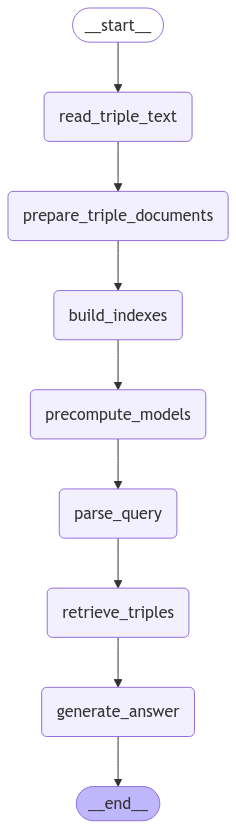

In [42]:
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass